# RNN Tutorial

Included in the data/names directory are 18 text files named as “[Language].txt”. Each file contains a bunch of names, one name per line, mostly romanized (but we still need to convert from Unicode to ASCII).

We’ll end up with a dictionary of lists of names per language, {language: [names ...]}. The generic variables “category” and “line” (for language and name in our case) are used for later extensibility.

In [1]:
from __future__ import unicode_literals, print_function, division
from io import open
import glob
import os

def findFiles(path): return glob.glob(path)

print(findFiles('./data/names/*.txt'))

import unicodedata
import string

all_letters = string.ascii_letters + " .,;'"
n_letters = len(all_letters)

# Turn a Unicode string to plain ASCII, thanks to https://stackoverflow.com/a/518232/2809427
def unicodeToAscii(s):
    return ''.join(
        c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn'
        and c in all_letters
    )

print(unicodeToAscii('Ślusàrski'))

# Build the category_lines dictionary, a list of names per language
category_lines = {}
all_categories = []

# Read a file and split into lines
def readLines(filename):
    lines = open(filename, encoding='utf-8').read().strip().split('\n')
    return [unicodeToAscii(line) for line in lines]

for filename in findFiles('./data/names/*.txt'):
    category = os.path.splitext(os.path.basename(filename))[0]
    all_categories.append(category)
    lines = readLines(filename)
    category_lines[category] = lines

n_categories = len(all_categories)

['./data/names\\Arabic.txt', './data/names\\Chinese.txt', './data/names\\Czech.txt', './data/names\\Dutch.txt', './data/names\\English.txt', './data/names\\French.txt', './data/names\\German.txt', './data/names\\Greek.txt', './data/names\\Irish.txt', './data/names\\Italian.txt', './data/names\\Japanese.txt', './data/names\\Korean.txt', './data/names\\Polish.txt', './data/names\\Portuguese.txt', './data/names\\Russian.txt', './data/names\\Scottish.txt', './data/names\\Spanish.txt', './data/names\\Vietnamese.txt']
Slusarski


### Turning Names into Tensors
Now that we have all the names organized, we need to turn them into Tensors to make any use of them.

To represent a single letter, we use a “one-hot vector” of size <1 x n_letters>. A one-hot vector is filled with 0s except for a 1 at index of the current letter, e.g. "b" = <0 1 0 0 0 ...>.

To make a word we join a bunch of those into a 2D matrix <line_length x 1 x n_letters>.

That extra 1 dimension is because PyTorch assumes everything is in batches - we’re just using a batch size of 1 here.

In [2]:
import torch

# Find letter index from all_letters, e.g. "a" = 0
def letterToIndex(letter):
    return all_letters.find(letter)

# Just for demonstration, turn a letter into a <1 x n_letters> Tensor
def letterToTensor(letter):
    tensor = torch.zeros(1, n_letters)
    tensor[0][letterToIndex(letter)] = 1
    return tensor

# Turn a line into a <line_length x 1 x n_letters>,
# or an array of one-hot letter vectors
def lineToTensor(line):
    tensor = torch.zeros(len(line), 1, n_letters)
    for li, letter in enumerate(line):
        tensor[li][0][letterToIndex(letter)] = 1
    return tensor

print(letterToTensor('J'))

print(lineToTensor('Jones').size())

tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0.]])
torch.Size([5, 1, 57])


### Creating the Network

In [3]:
import torch.nn as nn

class LSTM(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_class = 10):
        super(LSTM, self).__init__()
        self.hidden_dim = hidden_dim
        self.forget_gate = nn.Linear(in_features=input_dim + hidden_dim, out_features=hidden_dim)
        self.input_gate = nn.Linear(in_features=input_dim + hidden_dim, out_features=hidden_dim)
        self.cell_update = nn.Linear(in_features=input_dim + hidden_dim, out_features=hidden_dim)
        self.output_gate = nn.Linear(in_features=input_dim + hidden_dim, out_features=hidden_dim)
        self.classify = nn.Linear(in_features=hidden_dim, out_features=output_class)
        self.softmax = nn.LogSoftmax(dim=1)
        # self.device = device

    def forward(self, input):
        input_length = input.size()[0]
        hidden = torch.zeros(1, self.hidden_dim).to(input.device)
        cell = torch.zeros(1, self.hidden_dim).to(input.device)
        output = None
        for i in range(input_length):
            x = input[i]
            state = torch.concat((x, hidden), dim=-1)
            f = torch.sigmoid(self.forget_gate(state))
            i = torch.sigmoid(self.input_gate(state))
            c = torch.tanh(self.cell_update(state))
            cell = f * cell + i * c
            output = torch.sigmoid(self.output_gate(state))
            hidden = output * torch.tanh(cell)
        output = self.softmax(self.classify(output))
        return output
    
n_hidden = 128
lstm = LSTM(n_letters, n_hidden, output_class=n_categories)
print(lstm)

LSTM(
  (forget_gate): Linear(in_features=185, out_features=128, bias=True)
  (input_gate): Linear(in_features=185, out_features=128, bias=True)
  (cell_update): Linear(in_features=185, out_features=128, bias=True)
  (output_gate): Linear(in_features=185, out_features=128, bias=True)
  (classify): Linear(in_features=128, out_features=18, bias=True)
  (softmax): LogSoftmax(dim=1)
)


In [4]:
def categoryFromOutput(output):
    top_n, top_i = output.topk(1)
    category_i = top_i[0].item()
    return all_categories[category_i], category_i

We will also want a quick way to get a training example (a name and its language):

In [5]:
import random

def randomChoice(l):
    return l[random.randint(0, len(l) - 1)]

def randomTrainingExample():
    category = randomChoice(all_categories)
    line = randomChoice(category_lines[category])
    category_tensor = torch.tensor([all_categories.index(category)], dtype=torch.long)
    line_tensor = lineToTensor(line)
    return category, line, category_tensor, line_tensor

for i in range(10):
    category, line, category_tensor, line_tensor = randomTrainingExample()
    print('category =', category, '/ line =', line)

category = Irish / line = Bhrighde
category = Portuguese / line = Guerra
category = Arabic / line = Tuma
category = Chinese / line = Meng
category = Scottish / line = Muir
category = Spanish / line = De leon
category = Spanish / line = Mingo
category = Portuguese / line = Pereira
category = Korean / line = Kwak
category = Polish / line = Klimek


### Training the Network

In [6]:
learning_rate = 0.08
optimizer = torch.optim.SGD(lstm.parameters(), lr=learning_rate)
criterion = nn.NLLLoss()

Each loop of training will:

- Create input and target tensors
- Create a zeroed initial hidden state
- Read each letter in and keep hidden state for next letter
- Compare final output to target
- Back-propagate
- Return the output and loss

In [7]:
def train(category_tensor, line_tensor):
    optimizer.zero_grad()
    output = lstm(line_tensor)
    loss = criterion(output, category_tensor)
    loss.backward()
    optimizer.step()

    return output, loss.item()

Now we just have to run that with a bunch of examples. Since the train function returns both the output and loss we can print its guesses and also keep track of loss for plotting. Since there are 1000s of examples we print only every print_every examples, and take an average of the loss.

In [8]:
import time
import math

n_iters = 100000
print_every = 5000
plot_every = 1000

# Keep track of losses for plotting
current_loss = 0
current_acc = 0
all_losses = []
all_accs = []

def timeSince(since):
    now = time.time()
    s = now - since
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)

start = time.time()

for iter in range(1, n_iters + 1):
    category, line, category_tensor, line_tensor = randomTrainingExample()
    output, loss = train(category_tensor, line_tensor)
    current_loss += loss

    guess, _ = categoryFromOutput(output)
    if guess == category:
        current_acc += 1
    # Print iter number, loss, name and guess
    if iter % print_every == 0:
        guess, guess_i = categoryFromOutput(output)
        correct = '✓' if guess == category else '✗ (%s)' % category
        print('%d %d%% (%s) %.4f %s / %s %s' % (iter, iter / n_iters * 100, timeSince(start), loss, line, guess, correct))

    # Add current loss avg to list of losses
    if iter % plot_every == 0:
        all_losses.append(current_loss / plot_every)
        all_accs.append(current_acc / plot_every)
        current_loss = 0
        current_acc = 0

5000 5% (0m 18s) 3.7166 Chaim / Arabic ✗ (Chinese)
10000 10% (0m 41s) 3.2363 Szwarc / German ✗ (Polish)
15000 15% (1m 1s) 3.9402 Lang / Korean ✗ (German)
20000 20% (1m 21s) 1.9719 Parent / English ✗ (French)
25000 25% (1m 44s) 1.3178 Williamson / Scottish ✓
30000 30% (2m 6s) 0.4333 Rocha / Spanish ✓
35000 35% (2m 27s) 0.9606 Rodrigues / Portuguese ✓
40000 40% (2m 47s) 0.0674 Grigorishin / Russian ✓
45000 45% (3m 6s) 1.9191 Delaney / French ✗ (Irish)
50000 50% (3m 26s) 3.5802 Tremblay / Scottish ✗ (French)
55000 55% (3m 45s) 2.9520 Muggia / Czech ✗ (Italian)
60000 60% (4m 5s) 0.1226 Bursinos / Greek ✓
65000 65% (4m 24s) 0.0547 Fernandez / Spanish ✓
70000 70% (4m 40s) 0.4354 Poggio / Italian ✓
75000 75% (4m 56s) 1.6334 Von wegberg / German ✓
80000 80% (5m 11s) 2.0859 Rothschild / English ✗ (German)
85000 85% (5m 27s) 0.4558 Tholberg / Dutch ✓
90000 90% (5m 42s) 1.9508 Chamberlain / Irish ✗ (English)
95000 95% (5m 58s) 0.0261 Veen / Dutch ✓
100000 100% (6m 13s) 0.0085 Ha / Vietnamese ✓


### Plotting the Results
Plotting the historical loss from all_losses shows the network learning:

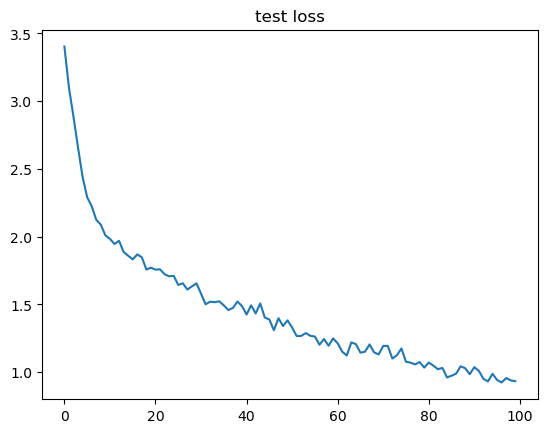

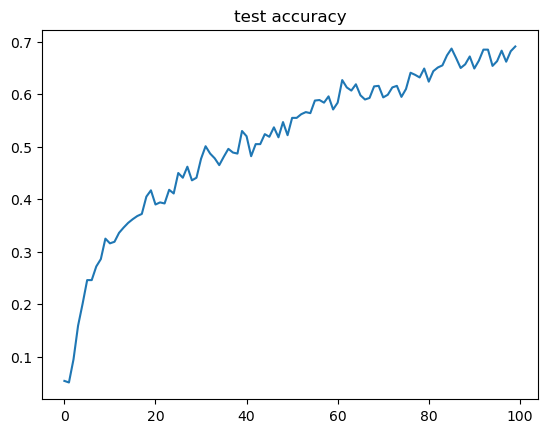

In [9]:
import os
os.environ['KMP_DUPLICATE_LIB_OK'] = 'True'
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

plt.figure()
plt.plot(all_losses)
plt.title('test loss');

plt.figure()
plt.plot(all_accs)
plt.title('test accuracy');

### Evaluating the Results
To see how well the network performs on different categories, we will create a confusion matrix, indicating for every actual language (rows) which language the network guesses (columns). To calculate the confusion matrix a bunch of samples are run through the network with evaluate(), which is the same as train() minus the backprop.

C:\Users\Lenovo\AppData\Local\Temp\ipykernel_8848\1990139428.py:28: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([''] + all_categories, rotation=90)
C:\Users\Lenovo\AppData\Local\Temp\ipykernel_8848\1990139428.py:29: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([''] + all_categories)


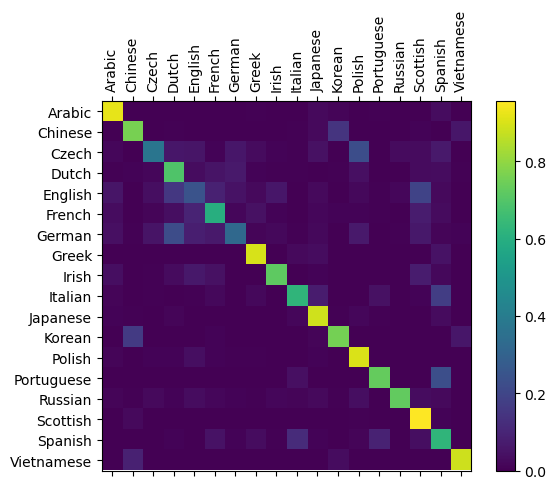

In [10]:
# Keep track of correct guesses in a confusion matrix
confusion = torch.zeros(n_categories, n_categories)
n_confusion = 10000

# Just return an output given a line
def evaluate(line_tensor):
    return lstm(line_tensor)

# Go through a bunch of examples and record which are correctly guessed
for i in range(n_confusion):
    category, line, category_tensor, line_tensor = randomTrainingExample()
    output = evaluate(line_tensor)
    guess, guess_i = categoryFromOutput(output)
    category_i = all_categories.index(category)
    confusion[category_i][guess_i] += 1

# Normalize by dividing every row by its sum
for i in range(n_categories):
    confusion[i] = confusion[i] / confusion[i].sum()

# Set up plot
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(confusion.numpy())
fig.colorbar(cax)

# Set up axes
ax.set_xticklabels([''] + all_categories, rotation=90)
ax.set_yticklabels([''] + all_categories)

# Force label at every tick
ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

# sphinx_gallery_thumbnail_number = 2
plt.show()

You can pick out bright spots off the main axis that show which languages it guesses incorrectly, e.g. Chinese for Korean, and Spanish for Italian. It seems to do very well with Greek, and very poorly with English (perhaps because of overlap with other languages).